In [1]:
import pandas as pd, numpy as np, matplotlib.pyplot as plt, networkx as nx 
from sklearn.cluster import KMeans 

In [2]:
from get_graph_from_data import get_graph, draw  
G_di, A_di, G_un, A_un = get_graph(data=pd.read_csv('archive/chicago_taxi_trips_2016_03.csv'), head=False) 
# draw(G_di) 
# draw(G_un) 
# A_un

<class 'networkx.utils.decorators.argmap'> compilation 8:4: FutureWarning: normalized_laplacian_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.


(array([ 6., 21.,  1.,  0.,  1.,  1.,  0., 41.,  1.,  5.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

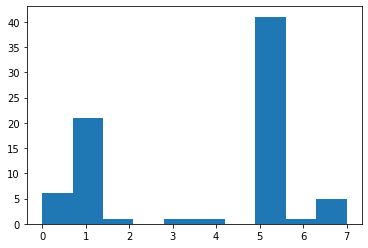

In [3]:
"""
Undirected Graphs: 
Spectral Clustering (Un-Normalized/Normalized)

"""
from scipy.sparse import csgraph 
from sklearn.preprocessing import normalize

def undirected_spectral_clustering(G, k=3, normalization=False): 
    if normalization: L = nx.normalized_laplacian_matrix(G).toarray() 
    else:             L = nx.laplacian_matrix(G).toarray() 
    
    vals, vecs = np.linalg.eig(L) 
    vecs = vecs[:,np.argsort(vals)] 
    vals = vals[np.argsort(vals)] 
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    clusters = kmeans.labels_
    best_cut = vecs[:,1] > 0 
    
    return clusters, best_cut 
clusters, best_cut = undirected_spectral_clustering(G_un, k=8, normalization=True) 
plt.hist(clusters)

/var/folders/_1/dc2yd0kn325bph09grgy33lr0000gn/T/ipykernel_67025/261227373.py:18: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(G).toarray()
/var/folders/_1/dc2yd0kn325bph09grgy33lr0000gn/T/ipykernel_67025/261227373.py:10: DeprecationWarning: 

The scipy.sparse array containers will be used instead of matrices
in Networkx 3.0. Use `to_scipy_sparse_array` instead.
  if method == 'straightforward': L = csgraph.laplacian(nx.to_scipy_sparse_matrix(G), normed=True).toarray()


(array([ 2., 12.,  6.,  0.,  5., 13.,  0.,  7.,  9., 23.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

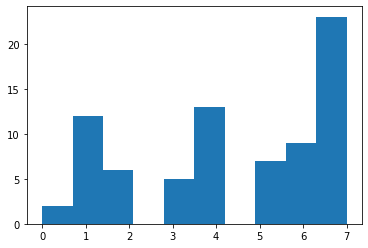

In [4]:
"""
Directed Graphs 
Spectral Clustering: 
    
"""
from scipy.sparse import csgraph 
from sklearn.preprocessing import normalize

def directed_spectral_clustering(G, k, method): 
    if method == 'straightforward': L = csgraph.laplacian(nx.to_scipy_sparse_matrix(G), normed=True).toarray() 
    if method == 'chung': L = nx.directed_laplacian_matrix(G) # Chung's Laplacian 
    if method == 'transformation1': 
        A = nx.adjacency_matrix(G).toarray() 
        A = A + A.T 
        G = nx.from_numpy_matrix(A) 
        return directed_spectral_clustering(G, k=k, method='straightforward')  
    if method == 'transformation2': 
        A = nx.adjacency_matrix(G).toarray() 
        A = (A.T)@A + A@(A.T) 
        G = nx.from_numpy_matrix(A) 
        return directed_spectral_clustering(G, k=k, method='straightforward') 
    vals, vecs = np.linalg.eig(L) 
    vecs = vecs[:,np.argsort(vals)] 
    vals = vals[np.argsort(vals)] 
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(vecs[:,1:k])
    clusters = kmeans.labels_
    best_cut = vecs[:,1] > 0 
    
    return clusters, best_cut 

clusters, best_cut = directed_spectral_clustering(G_di, k=8, method='transformation2') 
plt.hist(clusters) 

(array([69.,  1.,  1.,  0.,  1.,  2.,  0.,  1.,  1.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

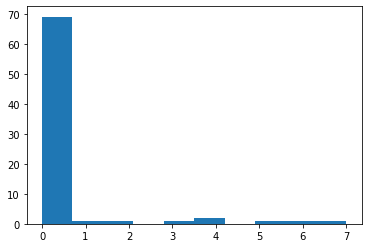

In [5]:
"""
Directed Graphs 
Spectral Clustering (Cont.)

SVD Spectral Clustering 
    
"""
from scipy.linalg import sqrtm, inv
def svd_spectral_clustering(A, d=32, k=8): 
    u, s, vh = np.linalg.svd(A, full_matrices=False) 
    U, S, Vh = u[:,:d], s[:d], vh[:d,:] 
    L = U*S@Vh 
    Z1 = U@inv(sqrtm(np.diag(S)))
    Z2 = (Vh.T)@inv(sqrtm(np.diag(S)))
    Z = np.concatenate((Z1, Z2), axis=1)
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(Z[:,1:k])
    clusters = kmeans.labels_
    
    return clusters 

clusters = svd_spectral_clustering(A_di) 
plt.hist(clusters)

# for i in range(5,75,5): 
#     print(i)
#     clusters = svd_spectral_clustering(A_di, d=i) 
#     plt.hist(clusters)
#     plt.show() 
#     plt.close() 

(array([41.,  1.,  2.,  0.,  1.,  8.,  0.,  1., 22.,  1.]),
 array([0. , 0.7, 1.4, 2.1, 2.8, 3.5, 4.2, 4.9, 5.6, 6.3, 7. ]),
 <BarContainer object of 10 artists>)

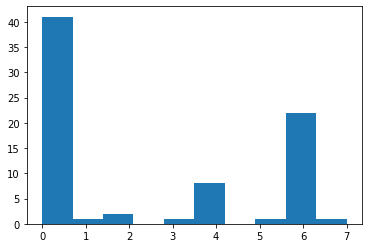

In [6]:
"""
Directed Graphs 
Spectral Clustering (Cont.)

Random Walk (RW) Spectral Clustering 
    
"""
from scipy.linalg import sqrtm, inv 
from scipy.ndimage import gaussian_filter1d

def rw_spectral_clustering(A, k=3): 
    D = np.diag(A.sum(axis=1)) 
    P = inv(D)@A 
    
    eigenValues, eigenVectors = np.linalg.eig(P)

    idx = eigenValues.argsort()[::-1]   
    eigenValues = eigenValues[idx]
    eigenVectors = eigenVectors[:,idx]

    # Second eigenvector 
    u = eigenVectors[:,1] 
    v = u.real + u.imag 
    w = gaussian_filter1d(v, sigma=1)
    
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(w.reshape(-1,1))
    clusters = kmeans.labels_
    
    return clusters 

clusters = rw_spectral_clustering(A_di, k=8) 
plt.hist(clusters) 

In [7]:
# """
# Spectral Clustering (Normalized; Sklearn)

# """

# from sklearn.cluster import SpectralClustering 
# sc = SpectralClustering(8, affinity='precomputed', n_init=100, assign_labels='discretize') 

# # Undirected Graph 
# clusters = sc.fit_predict(A_di)
# plt.hist(clusters) 

In [8]:
# # Directed Graph 
# clusters = sc.fit_predict(A_di) 
# plt.hist(clusters) 

In [9]:
# from sklearn.cluster import AgglomerativeClustering 

# clustering = AgglomerativeClustering(n_clusters=3).fit(A_un) 
# plt.hist(clustering.labels_) 

In [10]:
# import matplotlib.pyplot as plt
# import networkx as nx
# from networkx.algorithms.community.centrality import girvan_newman

# # G = nx.karate_club_graph()

# def gn_algorithm(G):
#     communities = girvan_newman(G)

#     node_groups = []
#     for com in next(communities): 
#         node_groups.append(list(com))

#     print(node_groups)

#     color_map = []
#     for node in G:
#         if node in node_groups[0]:
#             color_map.append('blue')
#         else: 
#             color_map.append('green')  
#     nx.draw(G, node_color=color_map, with_labels=True)
#     plt.show() 
#     return node_groups

In [11]:
# node_groups = gn_algorithm(G_di) 

In [12]:
# from sknetwork.hierarchy import Paris, cut_straight 
# from scipy.cluster.hierarchy import fcluster
# paris = Paris()
# dendrogram = paris.fit_transform(A_un)
# clusters = cut_straight(dendrogram, n_clusters=3)

# plt.hist(clusters)

In [13]:
# from HCS import labelled_HCS
# labels = labelled_HCS(nx.from_numpy_matrix(A_un))
# plt.hist(labels)